In [382]:
import numpy as np
import os
from typing import Tuple
import tensorflow as tf
from sklearn.utils import class_weight

# LSTM Classification

In [452]:
NUMBER_OF_TRAINING_DATA = 10
EPOCHS = 50

TRAINING_PATH = "../data_collection/datasets/training"
TEST_PATH = "../data_collection/datasets/test"

x_training = np.load(os.path.join(TRAINING_PATH, "class", "features.npy"), allow_pickle=True)
x_training = np.array([x_training[i].T for i in range(x_training.shape[0])])[-900:]
y_training = np.load(os.path.join(TRAINING_PATH, "class", "labels.npy"), allow_pickle=True)[-900:]

# Calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_training), y=y_training)

# Convert class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

INPUT_DIM = x_training.shape[1:]

x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('int32'))

# x_training = x_training.astype('float32')
# y_training = y_training.astype('int32')
# y_training = tf.one_hot(y_training, 5)



In [458]:
class_weights = tf.cast(tf.constant(class_weights), "float32")
class_weights

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([1.6071428 , 1.5517242 , 0.46391752, 1.3533834 , 1.192053  ],
      dtype=float32)>

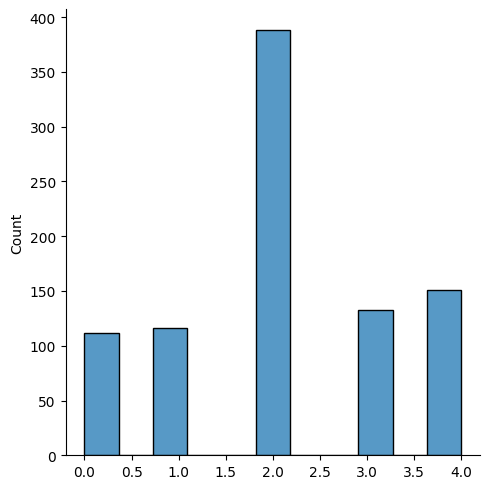

In [454]:
import seaborn as sns

sns.displot(y_training)

In [455]:
def weightedLoss(weights=tf.constant([1,1,1,1,1])):
    def innerLoss(true, pred):
        w = tf.gather(weights, true) #(batch, labels, 1)

        loss = tf.keras.backend.sparse_categorical_crossentropy(true, pred) #(batch, labels)
        loss = w * loss

        return loss

    return innerLoss

In [537]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler_plt = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.005)
lr_scheduler_exp = tf.keras.optimizers.schedules.ExponentialDecay(0.005, 100, 0.9, staircase=True)

In [619]:
def create_lstm_model(input_shape:Tuple[int, int]) -> tf.keras.Model:
    
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.LSTM(64, activation="tanh", dropout=0.1, return_sequences=True),
        tf.keras.layers.LSTM(86, activation="tanh", return_sequences=True),
        tf.keras.layers.LSTM(128, activation="tanh"),
        # tf.keras.layers.Dense(128, activation="relu"),
        # tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(5, activation="softmax")
    ])

    model.compile(
        # loss=weightedLoss(class_weights),
        loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.005, epsilon=3e-03),
        metrics=["acc"]
    )

    return model

In [620]:
model = create_lstm_model(INPUT_DIM)

In [621]:

history = model.fit(x_training, 
                    y_training, 
                    validation_split=0.10,
                    epochs=EPOCHS, 
                    batch_size=100,
                    # callbacks=[lr_scheduler]
                    )

Epoch 1/50
9/9 [==============================] - 33s 2s/step - loss: 1.5099 - acc: 0.4099 - val_loss: 1.4292 - val_acc: 0.4778
Epoch 2/50
9/9 [==============================] - 5s 562ms/step - loss: 1.4778 - acc: 0.4259 - val_loss: 1.4138 - val_acc: 0.4778
Epoch 3/50
9/9 [==============================] - 3s 293ms/step - loss: 1.4707 - acc: 0.4259 - val_loss: 1.4239 - val_acc: 0.4778
Epoch 4/50
9/9 [==============================] - 3s 340ms/step - loss: 1.4714 - acc: 0.4259 - val_loss: 1.5105 - val_acc: 0.4111
Epoch 5/50
9/9 [==============================] - 2s 165ms/step - loss: 1.4772 - acc: 0.3926 - val_loss: 1.4249 - val_acc: 0.4778
Epoch 6/50
9/9 [==============================] - 2s 235ms/step - loss: 1.4604 - acc: 0.4259 - val_loss: 1.4590 - val_acc: 0.4778
Epoch 7/50
9/9 [==============================] - 1s 131ms/step - loss: 1.4548 - acc: 0.4259 - val_loss: 1.4233 - val_acc: 0.4778
Epoch 8/50
9/9 [==============================] - 1s 154ms/step - loss: 1.4367 - acc: 0.4259

In [622]:
model.summary()

Model: "sequential_120"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_305 (LSTM)             (None, 23, 64)            25856     
                                                                 
 lstm_306 (LSTM)             (None, 23, 86)            51944     
                                                                 
 lstm_307 (LSTM)             (None, 128)               110080    
                                                                 
 dense_250 (Dense)           (None, 5)                 645       
                                                                 
Total params: 188,525
Trainable params: 188,525
Non-trainable params: 0
_________________________________________________________________


In [623]:
accuracy = history.history["acc"]
val_accuracy = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

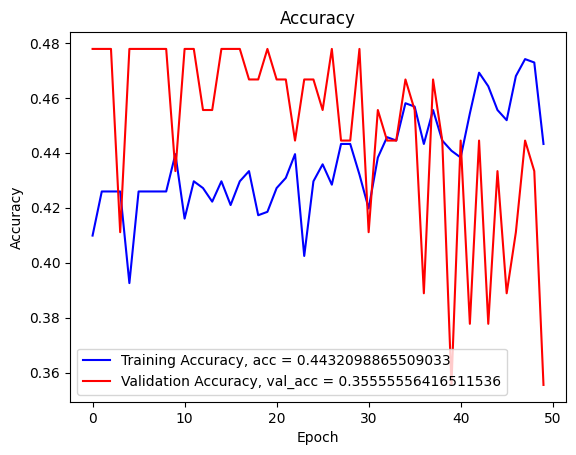

In [624]:
import matplotlib.pyplot as plt
plt.plot(range(len(accuracy)), accuracy, "b", label = f"Training Accuracy, acc = {accuracy[-1]}")
plt.plot(range(len(accuracy)), val_accuracy, "-r", label = f"Validation Accuracy, val_acc = {val_accuracy[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

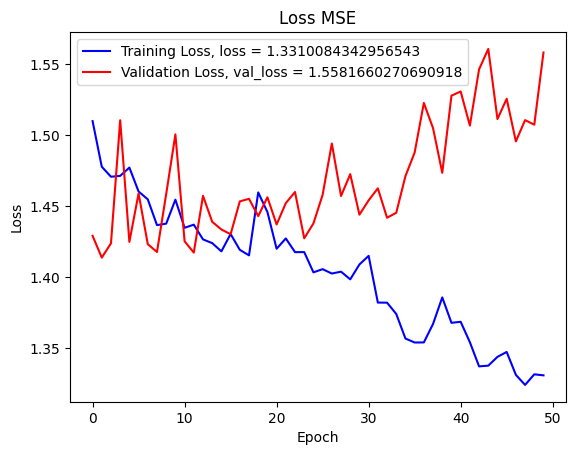

In [625]:
plt.plot(range(EPOCHS), loss, "b", label = f"Training Loss, loss = {loss[-1]}")
plt.plot(range(EPOCHS), val_loss, "-r", label = f"Validation Loss, val_loss = {val_loss[-1]}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss MSE")
plt.show()

In [561]:
x_test = np.load(os.path.join(TEST_PATH, "class", "features.npy"), allow_pickle=True)
x_test = np.array([x_test[i].T for i in range(x_test.shape[0])])
y_test = np.load(os.path.join(TEST_PATH, "class", "labels.npy"), allow_pickle=True)

INPUT_DIM = x_test.shape[1:]

x_test = tf.convert_to_tensor(x_test.astype('float32'))
y_test = tf.convert_to_tensor(y_test.astype('int32'))
# y_test = tf.one_hot(y_test, 5)

In [562]:
model.evaluate(x_test, y_test)

13/13 [==============================] - 2s 67ms/step - loss: 1.5929 - acc: 0.3797


[1.5928624868392944, 0.37974682450294495]

In [569]:
from sklearn.metrics import classification_report, confusion_matrix
#Predict
y_prediction = model.predict(x_test)

y_prediction = np.argmax(y_prediction, axis=1)
#Create confusion matrix and normalizes it over predicted (columns)
result = classification_report(y_test, y_prediction)
print(result)

13/13 [==============================] - 0s 9ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        42
           1       0.08      0.04      0.05        57
           2       0.48      0.71      0.57       191
           3       0.13      0.04      0.06        51
           4       0.19      0.19      0.19        54

    accuracy                           0.38       395
   macro avg       0.18      0.19      0.17       395
weighted avg       0.29      0.38      0.32       395



In [567]:
y_pred = model.predict(x_test)
np.argmax(y_pred, axis=1)

13/13 [==============================] - 0s 34ms/step


array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 2, 0, 2, 2, 1, 1, 2, 1, 3, 3, 2, 2, 2, 1, 2,
       2, 1, 2, 1, 2, 2, 2, 1, 3, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 4, 4, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 4, 4, 2, 2, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 0, 1, 2, 0, 2, 2, 2, 1, 2,
       3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 4, 2, 2, 4, 2, 4, 4, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4,
       3, 2, 2, 3, 2, 2, 4, 4, 2, 3, 3, 2, 1, 2, 3, 3, 2, 1, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 0, 4, 4, 2, 1, 0, 2, 2, 2, 3,
       2, 2, 2, 4, 2, 2, 4, 4, 0, 0, 2, 2, 0, 0, 2,

In [566]:
y_pred

array([[0.15218654, 0.268764  , 0.35798487, 0.21063082, 0.01043371],
       [0.13043077, 0.14116749, 0.38252276, 0.07958598, 0.26629308],
       [0.06825912, 0.04465356, 0.39003047, 0.34141204, 0.15564482],
       ...,
       [0.00800981, 0.06336197, 0.73909104, 0.1703859 , 0.01915136],
       [0.00469075, 0.06214117, 0.8445268 , 0.08332817, 0.00531311],
       [0.01775243, 0.210053  , 0.67133063, 0.08640743, 0.01445642]],
      dtype=float32)

In [475]:
y_test

<tf.Tensor: shape=(395,), dtype=int32, numpy=
array([3, 0, 3, 3, 0, 1, 4, 2, 1, 4, 0, 1, 1, 0, 0, 4, 0, 0, 2, 2, 3, 0,
       3, 0, 3, 1, 2, 3, 1, 2, 2, 0, 1, 3, 2, 4, 2, 0, 2, 1, 2, 2, 2, 2,
       2, 2, 0, 0, 1, 0, 2, 2, 0, 2, 0, 4, 2, 2, 1, 4, 3, 2, 1, 2, 1, 1,
       2, 2, 2, 2, 3, 2, 3, 3, 2, 2, 1, 1, 1, 4, 4, 3, 4, 2, 4, 2, 2, 3,
       1, 2, 3, 0, 2, 4, 4, 2, 2, 2, 1, 2, 2, 2, 4, 1, 2, 4, 1, 4, 2, 3,
       2, 1, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 3, 0, 2, 1, 4, 2, 2, 2, 2, 2,
       2, 3, 1, 3, 2, 4, 3, 2, 1, 0, 3, 0, 1, 2, 0, 3, 1, 0, 4, 2, 2, 2,
       3, 2, 2, 2, 2, 2, 1, 3, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2,
       2, 2, 2, 2, 2, 4, 1, 4, 4, 0, 4, 4, 1, 2, 2, 0, 2, 4, 2, 0, 2, 0,
       0, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 3, 3,
       2, 2, 1, 3, 2, 2, 1, 3, 2, 2, 2, 2, 3, 2, 1, 0, 3, 2, 2, 4, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 4, 2, 3, 2, 3, 4, 3, 4, 3, 4,
       4, 2, 3, 2, 0, 4, 4, 1, 2, 2, 0, 4, 2, 2, 1, 4, 0, 2, 4, 2, 3, 2,
     

# LSTM Regression

In [640]:
NUMBER_OF_TRAINING_DATA = 10
EPOCHS = 50

TRAINING_PATH = "../data_collection/datasets/training"
TEST_PATH = "../data_collection/datasets/test"

x_training = np.load(os.path.join(TRAINING_PATH, "reg", "features.npy"), allow_pickle=True)
x_training = np.array([x_training[i].T for i in range(x_training.shape[0])])[-900:]
y_training = np.load(os.path.join(TRAINING_PATH, "reg", "labels.npy"), allow_pickle=True)[-900:]


INPUT_DIM = x_training.shape[1:]

x_training = tf.convert_to_tensor(x_training.astype('float32'))
y_training = tf.convert_to_tensor(y_training.astype('float32'))

# x_training = x_training.astype('float32')
# y_training = y_training.astype('int32')
# y_training = tf.one_hot(y_training, 5)



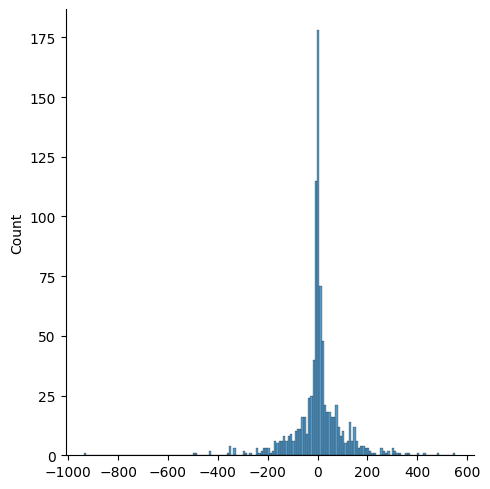

In [627]:
import seaborn as sns

sns.displot(y_training)

In [642]:
def normalize(x):
    x = np.array(x)
    mx = x.max()
    mn = x.min()
    return (mx - x) / (mx - mn)


y_training = tf.math.log(y_training)

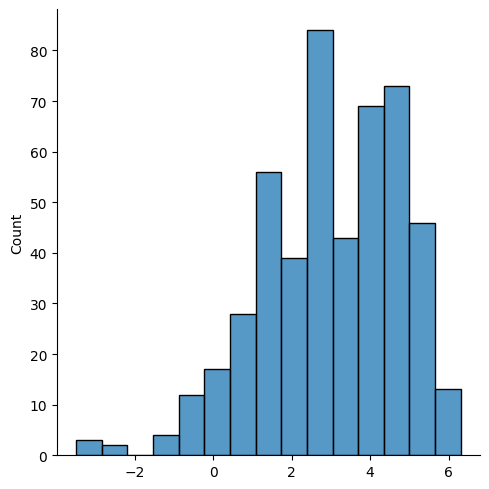

In [643]:
sns.displot(y_training)

In [644]:
y_training = tf.math.exp(y_training)

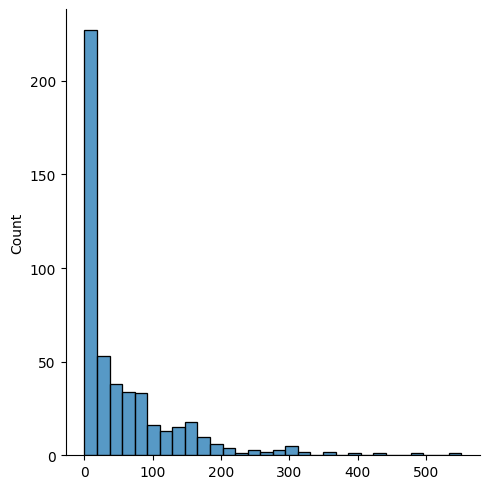

In [645]:
sns.displot(y_training)